In [29]:
import os
import numpy as np
import pandas as pd
from random import shuffle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, Subset, Sampler

sys.path.append(os.path.abspath('../utils'))


from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

In [2]:
def show_embeddings(vectors, y=None):
    
    # reduce dimensions with TSNE
    trans_vectors = TSNE(
        n_components=2, learning_rate='auto', init='random', perplexity=5
    ).fit_transform(vectors)
    
    # create legend if labels are known
    colors = None
    if y is not None:
        
        # create color map from unique labels
        labels = np.unique(y)
        label_idx = {k: v for k, v in zip(labels, range(len(labels)))}
        cmap = plt.cm.get_cmap('gist_rainbow', len(labels))
        colors = [cmap(label_idx[i]) for i in y]
        
        # add legend labels manually
        patches = [mpatches.Patch(color=cmap(i), label=label) for i, label in enumerate(labels)]
        plt.legend(handles=patches, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    
    plt.scatter(
        trans_vectors[:, 0],
        trans_vectors[:, 1],
        c=colors, alpha=1
    )
    return

def cutpad(arr):
    """
    Removes padding from array
    """
    return arr[arr != 0]

In [102]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, spec_cols, series_cols, time_cols):
        self.df = df
        self.spec_cols = spec_cols
        self.series_cols = series_cols
        self.time_cols = time_cols
        self.specs = df['id'].unique()
        self.supplier = [
            df.loc[df['id'] == spec_id]['supplier'].iloc[0]
            for spec_id in self.specs
        ]

    def __len__(self):
        return len(self.specs)

    def __getitem__(self, idx):
        data = self.df.loc[self.df['id'] == self.specs[idx]]
        
        h = torch.tensor(data[self.spec_cols].iloc[0].values, dtype=torch.float)
        x = torch.tensor(data[self.series_cols].values, dtype=torch.float)
        t = torch.tensor(data[self.time_cols].values, dtype=torch.float)
        
        return h, x, t

def pad_collate(batch):
    max_len = max([len(sample[1]) for sample in batch])
    new_batch = []
    for sample in batch:
        repeat_n = max_len - len(sample[1])
        
        sample_h = sample[0]
        sample_x = torch.cat((sample[1], sample[1][-1].unsqueeze(0).repeat(repeat_n, 1)))
        sample_t = torch.cat((sample[2], sample[2][-1].unsqueeze(0).repeat(repeat_n, 1)))
        
        new_batch.append((
            sample_h, 
            sample_x,
            sample_t
        ))
    
    h = torch.stack([sample[0] for sample in new_batch])
    x = torch.stack([sample[1] for sample in new_batch])
    t = torch.stack([sample[2] for sample in new_batch])
    return h, x, t

class SequenceLengthSampler(Sampler):

    def __init__(self, ind_n_len, bucket_boundaries, batch_size=64,):
        self.ind_n_len = ind_n_len
        self.bucket_boundaries = bucket_boundaries
        self.batch_size = batch_size
        
        
    def __iter__(self):
        data_buckets = dict()
        # where p is the id number and seq_len is the length of this id number. 
        for p, seq_len in self.ind_n_len:
            pid = self.element_to_bucket_id(p,seq_len)
            if pid in data_buckets.keys():
                data_buckets[pid].append(p)
            else:
                data_buckets[pid] = [p]

        for k in data_buckets.keys():

            data_buckets[k] = np.asarray(data_buckets[k])

        iter_list = []
        for k in data_buckets.keys():
            np.random.shuffle(data_buckets[k])
            iter_list += (np.array_split(data_buckets[k]
                           , int(data_buckets[k].shape[0]/self.batch_size)))
        shuffle(iter_list) # shuffle all the batches so they arent ordered by bucket
        # size
        for i in iter_list: 
            yield i.tolist() # as it was stored in an array
    
    def __len__(self):
        return len(self.data_source)
    
    def element_to_bucket_id(self, x, seq_length):
        boundaries = list(self.bucket_boundaries)
        buckets_min = [np.iinfo(np.int32).min] + boundaries
        buckets_max = boundaries + [np.iinfo(np.int32).max]
        conditions_c = np.logical_and(
          np.less_equal(buckets_min, seq_length),
          np.less(seq_length, buckets_max))
        bucket_id = np.min(np.where(conditions_c))
        return bucket_id

In [71]:
class Seq2SeqAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(Seq2SeqAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True)

    def forward(self, x):
        _, (hidden, _) = self.encoder(x)
        hidden = hidden.repeat(x.shape[1], 1, 1).permute(1, 0, 2)
        output, _ = self.decoder(hidden)
        return output

In [107]:
spec_cols = ['supplier_status', 'volume_contracted', 'spec_price', 'delivery_period_lenght']
delivery_cols = ['price_change', 'lateness_percentage', 'weight_percentage']
time_cols = ['month', 'day', 'weekday']

data = pd.read_csv('../data/final_data/data.csv')
dataset = TimeSeriesDataset(data, spec_cols, delivery_cols, time_cols)

bucket_boundaries = [2, 4, 6, 7, 10, 15, 20, 30, 40, 60, 80, 100, 140]
lengths = [(i, len(item[1])) for i, item in enumerate(dataset)]
sampler = SequenceLengthSampler(lengths, bucket_boundaries, batch_size=8)

dataloader = DataLoader(dataset, collate_fn=pad_collate, batch_sampler=sampler)

In [135]:
model = Seq2SeqAutoencoder(3, 12, 3, 1)

In [136]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [167]:
for epoch in range(100):
    accumulated_loss = []
    for i, (h, x, t) in enumerate(dataloader):
        output = model(x)
        loss = criterion(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        accumulated_loss.append(loss.item())
        
        if i % 100 == 0:
            print(np.mean(accumulated_loss))

0.18313659727573395
0.3673374168021549
0.3451883356684624
0.33733727082771026
2.170351982116699
0.3573219887727853
0.37120086850774525
0.3467033653337496
0.25192636251449585
0.361475068006185
0.34806176659590865
0.32699095520293
1.679496169090271
0.30380558025202536
0.32544861358604327
0.3331593932751009
0.0653860941529274
0.37791066775375076
0.38033813638473624
0.354152354513886
1.0531703233718872
0.38846147318582724
0.3562268234455763
0.33736319973000456
0.5252380967140198
0.3216978741238023
0.36172118398421144
0.3359222586801975
0.10030707716941833
0.33579728660164493
0.3365594229443156
0.3333025459460048
0.3658042550086975
0.40960464525119505
0.3734061206639999
0.3431447470727751
0.16238845884799957
0.35058725693512083
0.3295624312940077
0.3320117435755326
0.797128438949585
0.3964871005477882
0.33540774472243157
0.31343052009634204
1.3663605451583862
0.36585359004243173
0.3269108175137891
0.344809248826878
0.0818631649017334
0.3232506718670968
0.3359966404661907
0.330973465855781
0

KeyboardInterrupt: 

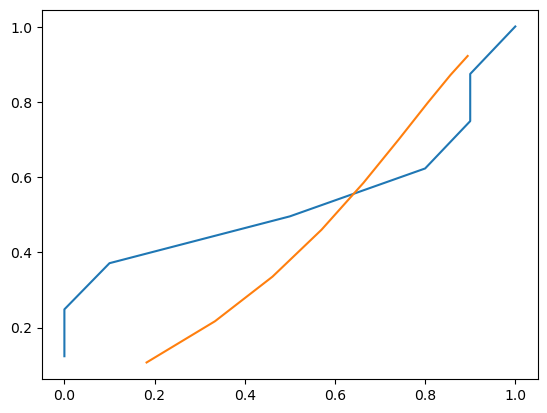

In [168]:
i = 7
plt.plot(x[i, :, -2], x[i, :, -1])
plt.plot(output[i, :, -2].detach(), output[i, :, -1].detach())

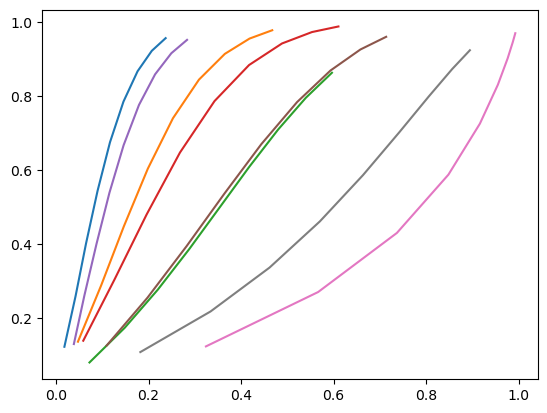

In [169]:
for i in range(len(output)):
    plt.plot(output[i, :, -2].detach(), output[i, :, -1].detach())

In [171]:
output[0]

tensor([[-0.2639,  0.0182,  0.1217],
        [-0.1747,  0.0423,  0.2584],
        [-0.1896,  0.0650,  0.4008],
        [-0.1720,  0.0899,  0.5431],
        [-0.1649,  0.1167,  0.6743],
        [-0.1558,  0.1458,  0.7840],
        [-0.1497,  0.1763,  0.8661],
        [-0.1456,  0.2071,  0.9214],
        [-0.1437,  0.2370,  0.9556]], grad_fn=<SelectBackward0>)

In [172]:
x[0]

tensor([[ 0.4198,  0.0000,  0.1170],
        [-1.0223,  0.0000,  0.2388],
        [-2.1935,  0.0000,  0.3351],
        [-0.1095,  0.1111,  0.4545],
        [ 0.9492,  0.1111,  0.5506],
        [ 1.2805,  0.1111,  0.6548],
        [ 0.8304,  0.1111,  0.7502],
        [ 0.4824,  0.2222,  0.8691],
        [-0.8952,  0.2222,  1.0000]])

In [18]:
supplier_set = {
    'Барсукова Е.С. ИП Глава К(Ф)Х',
    'Донченко В.С. ИП Глава К(Ф)Х',
    'АГРОПРОМ ООО', 'ИНТЕРПРОМ ООО', 'ДОНСКИЕ ЗОРИ ООО'
}
indexes = np.where([
    (supplier in supplier_set) for supplier in dataset.supplier
])[0]

In [19]:
seqs = [dataset[i] for i in indexes]
suppliers = [dataset.supplier[i] for i in indexes]
embs = np.stack([model.encoder(seq.unsqueeze(0))[1][0].squeeze().detach().numpy() for seq in seqs])

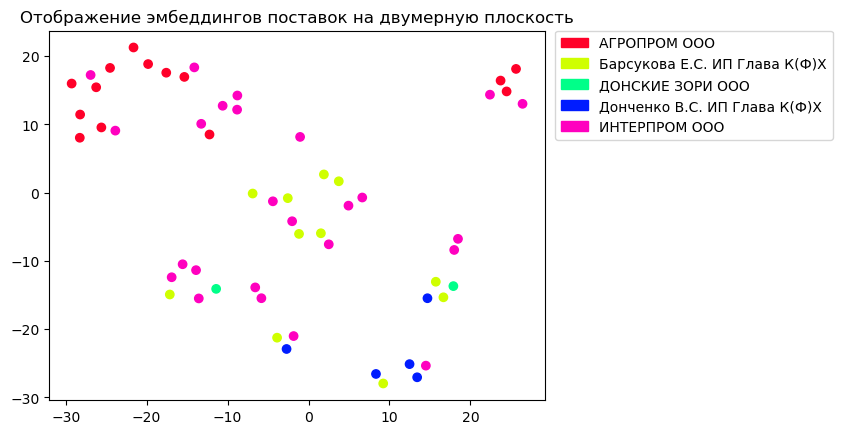

In [21]:
plt.title('Отображение эмбеддингов поставок на двумерную плоскость')
show_embeddings(embs, suppliers)
plt.savefig('../figures/tsne_spec_embedings.jpg', bbox_inches='tight')

In [93]:
X, y = next(iter(dataloader))

In [31]:
class BySequenceLengthSampler(Sampler):

    def __init__(self, ind_n_len, bucket_boundaries, batch_size=64,):
        self.ind_n_len = ind_n_len
        self.bucket_boundaries = bucket_boundaries
        self.batch_size = batch_size
        
        
    def __iter__(self):
        data_buckets = dict()
        # where p is the id number and seq_len is the length of this id number. 
        for p, seq_len in self.ind_n_len:
            pid = self.element_to_bucket_id(p,seq_len)
            if pid in data_buckets.keys():
                data_buckets[pid].append(p)
            else:
                data_buckets[pid] = [p]

        for k in data_buckets.keys():

            data_buckets[k] = np.asarray(data_buckets[k])

        iter_list = []
        for k in data_buckets.keys():
            np.random.shuffle(data_buckets[k])
            iter_list += (np.array_split(data_buckets[k]
                           , int(data_buckets[k].shape[0]/self.batch_size)))
        shuffle(iter_list) # shuffle all the batches so they arent ordered by bucket
        # size
        for i in iter_list: 
            yield i.tolist() # as it was stored in an array
    
    def __len__(self):
        return len(self.data_source)
    
    def element_to_bucket_id(self, x, seq_length):
        boundaries = list(self.bucket_boundaries)
        buckets_min = [np.iinfo(np.int32).min] + boundaries
        buckets_max = boundaries + [np.iinfo(np.int32).max]
        conditions_c = np.logical_and(
          np.less_equal(buckets_min, seq_length),
          np.less(seq_length, buckets_max))
        bucket_id = np.min(np.where(conditions_c))
        return bucket_id

In [124]:
lengths = torch.tensor([len(item) for item in data])
sampler = BucketBatchSampler(lengths, batch_size=2)
loader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler, collate_fn=pad_collate)

In [125]:
lengths

tensor([3, 5, 2, 4])

In [126]:
X, y = next(iter(loader))

In [127]:
X

tensor([[1., 2., 0., 0.],
        [1., 2., 3., 4.]])

In [133]:
for X, y in loader:
    print(X)

tensor([[1., 2., 3., 4., 0.],
        [1., 2., 3., 4., 5.]])
tensor([[1., 2., 3.],
        [1., 2., 0.]])
